In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline
import tensorflow as tf
from tensorflow import keras 
import numpy as np
import sklearn
import pandas as pd
import sys, os, shutil
print(tf.__version__)
print(sys.version_info)

2.0.0
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


## Load Data

In [2]:
fashion_mnist = keras.datasets.fashion_mnist #https://www.tensorflow.org/datasets/catalog/fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

## Dimensionality checking

In [3]:
print("training set size:")
print(x_train.shape, y_train.shape)
print("validation set size:")
print(x_valid.shape, y_valid.shape)
print("testing set size:")
print(x_test.shape, y_test.shape)

training set size:
(55000, 28, 28) (55000,)
validation set size:
(5000, 28, 28) (5000,)
testing set size:
(10000, 28, 28) (10000,)


## Show images (just for a better sense of how fashion-mnist looks like)

In [4]:
def show_single_image(img_arr):
	plt.imshow(img_arr, cmap="binary")
	plt.show()

def show_imgs(n_rows, n_cols, x_data, y_data, class_names):
	assert len(x_data) == len(y_data)
	assert n_rows * n_cols < len(x_data)
	plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))
	for row in range(n_rows):
		for col in range(n_cols):
			index = n_cols * row + col 
			plt.subplot(n_rows, n_cols, index+1)
			plt.imshow(x_data[index], cmap="binary", interpolation = 'nearest')
			plt.axis('off')
			plt.title(class_names[y_data[index]])
	plt.show()

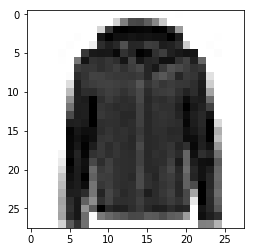

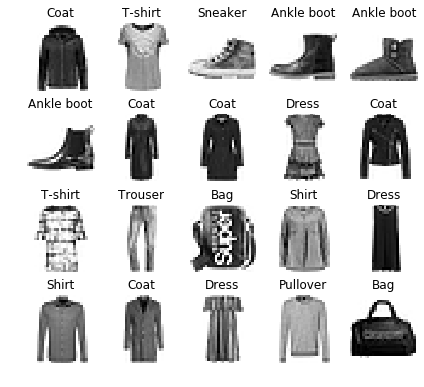

In [5]:
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

show_single_image(x_train[0])
show_imgs(4, 5, x_train, y_train, class_names) # show a plot with 4x5 subplots


## Standardization

In [6]:
# https://scikit-learn.org/stable/modules/preprocessing.html
# x = (x-u)/std to make x with mean 0 and std 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
# use the mean and std of training set to do standardization for validation/testing set
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

## Build the model with keras.Sequential API

In [7]:
# relu: y=max(0, x)
# softmax: x = [2, 3, 8]
#          sum = e^2 + e^3 + e^8
#          y = [e^2/sum, e^3/sum, e^8/sum] sum up to 1 (as probability)
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # 28x28 image -> 784
model.add(keras.layers.Dense(300, activation="relu")) #fully connected layer 1
model.add(keras.layers.Dense(100, activation="relu")) #fully connected layer 2
model.add(keras.layers.Dense(10, activation="softmax")) # output layer

In [ ]:
""" another way of using keras.sequential API
model = keras.models.Sequential(
	keras.layers.Flatten(input_shape=[28, 28]),
	keras.layers.Dense(300, activation="relu"),
	keras.layers.Dense(100, activation="relu"),
	keras.layers.Dense(10, activation="softmax"))
"""

## Compile the model


In [8]:
#reference links
# cross entropy
#https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy?hl=en
# sgd
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD
model.compile(loss="sparse_categorical_crossentropy",
				optimizer=keras.optimizers.SGD(0.001),
				metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


## callback functions

In [9]:
# https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks
# keras.callbacks.Tensorboard: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks/TensorBoard
# keras.callbacks.ModelCheckpoint: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks/ModelCheckpoint
# keras.callbacks.EarlyStopping: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks/EarlyStopping
# check tensorboard record: tensorboard --logdir=Log_Dir_You_Saved_The_Logs

logdir = "/Users/yantinghuang/Study/BIOS534_Yu_spring2019/log_dir_classification" # change to your preferred directory path
if not os.path.exists(logdir):
	os.mkdir(logdir)
output_model_fn = os.path.join(logdir, "fashion_mnist_model.h5")
callbacks = [
		keras.callbacks.TensorBoard(logdir),
		keras.callbacks.ModelCheckpoint(output_model_fn,save_best_only=True),
		keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)]

## Model Training

In [10]:
history = model.fit(x_train_scaled, y_train, epochs=10,
	validation_data=(x_valid_scaled, y_valid),
	callbacks=callbacks)
print(history.history)


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 10s 188us/sample - loss: 0.9178 - accuracy: 0.6949 - val_loss: 0.6225 - val_accuracy: 0.7834
Epoch 2/10
55000/55000 [==============================] - 8s 143us/sample - loss: 0.5892 - accuracy: 0.7942 - val_loss: 0.5272 - val_accuracy: 0.8162
Epoch 3/10
55000/55000 [==============================] - 7s 135us/sample - loss: 0.5200 - accuracy: 0.8159 - val_loss: 0.4874 - val_accuracy: 0.8274
Epoch 4/10
55000/55000 [==============================] - 8s 138us/sample - loss: 0.4821 - accuracy: 0.8273 - val_loss: 0.4551 - val_accuracy: 0.8420
Epoch 5/10
55000/55000 [==============================] - 8s 137us/sample - loss: 0.4567 - accuracy: 0.8370 - val_loss: 0.4362 - val_accuracy: 0.8500
Epoch 6/10
55000/55000 [==============================] - 7s 131us/sample - loss: 0.4378 - accuracy: 0.8440 - val_loss: 0.4231 - val_accuracy: 0.8548
Epoch 7/10
55000/55000 [==========================

## Plot training history

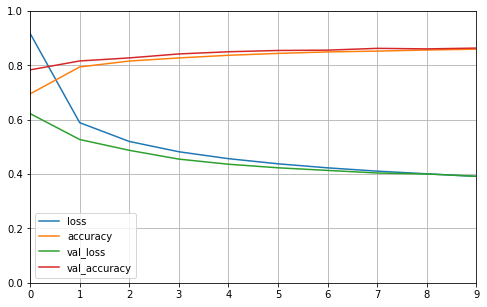

In [11]:
def plot_learning_curves(history):
	pd.DataFrame(history.history).plot(figsize=(8, 5))
	plt.grid(True)
	plt.gca().set_ylim(0, 1)
	plt.show()
plot_learning_curves(history)